In [159]:
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Gas Natural

In [160]:
gasn = pd.read_csv('data_materias_eur/GAS-EUR.csv')

In [161]:
gasn = gasn.drop(columns=['Open','High', 'Low', 'Adj Close', 'Volume' ])  #eliminamos columnas innecesarias

gasn['Date'] = pd.to_datetime(gasn['Date'])  #convertimos a fecha

In [162]:
gasn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1976 non-null   datetime64[ns]
 1   Close   1976 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


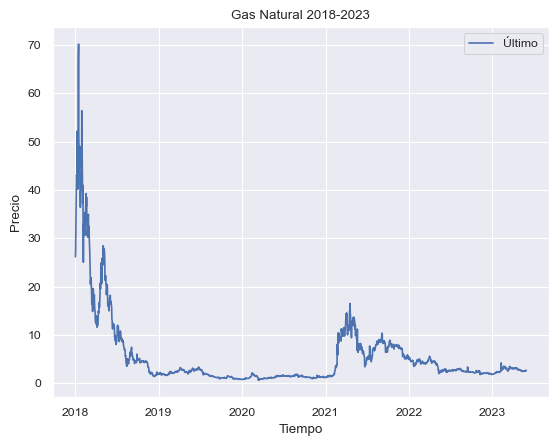

In [163]:
sns.lineplot(x=gasn.Date,y=gasn['Close'], data=gasn['Close'])

plt.title('Gas Natural 2018-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

Relleno los fines de semana

In [164]:
import datetime

In [165]:
gasn = gasn.set_index('Date')
date_range = pd.date_range(start=gasn.index.min(), end=gasn.index.max())
filled_gasn = pd.merge(pd.DataFrame(date_range, columns=['Date']), gasn, how='left', left_on='Date', right_index=True)

filled_gasn = filled_gasn.fillna(method='ffill')



In [166]:
filled_gasn.head()

,Date,Close
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


Test DickeyFuller

In [167]:
from statsmodels.tsa.stattools import adfuller

y = filled_gasn.Close
result = adfuller(y)
print('Dickey-Fuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Dickey-Fuller Statistic: -5.452756
p-value: 0.000003
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Dickey-Fuller me dice que es estacionaria por lo tanto se debería poder hacer el modelo con ARIMA 

## ARIMA

In [168]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# splitting into train and test sets

#poner el limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]



## SARIMA

Test RMSE: 0.091


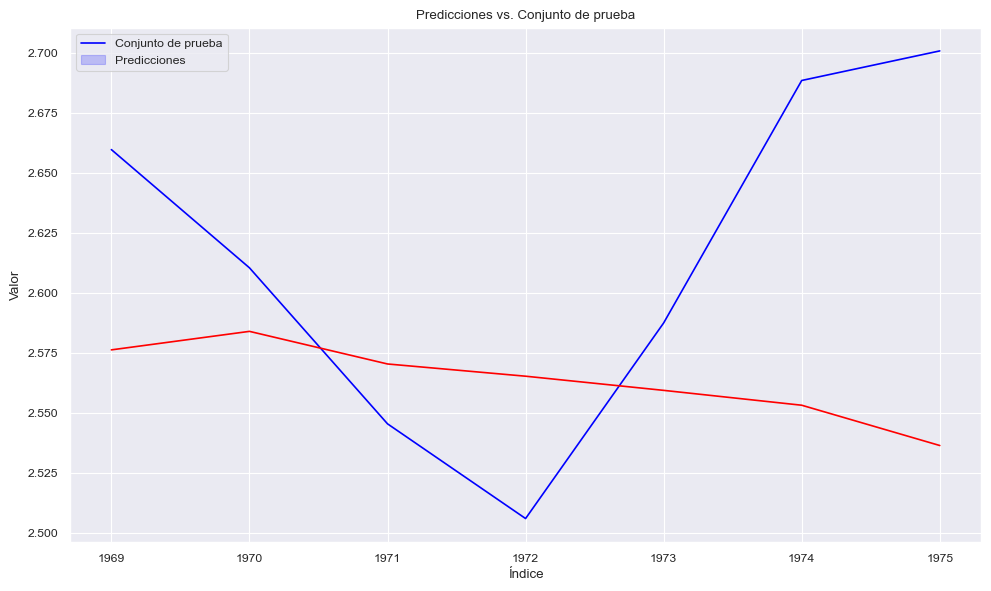

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA con un paso de tiempo diario
model = SARIMAX(train_gasn['Close'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit()

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.predict(start=index, end=len(filled_gasn)-1, dynamic=False)

# Calcular el error cuadrático medio (RMSE)
rmse = mean_squared_error(test_gasn['Close'], predictions, squared=False)
print('Test RMSE: %.3f' % rmse)

# Graficar las predicciones contra los valores reales

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

# Tramar el conjunto de prueba y las predicciones
sns.lineplot(data=test_gasn['Close'], color='blue')
sns.lineplot(data=predictions, color='red')

plt.title('Predicciones vs. Conjunto de prueba')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend(['Conjunto de prueba', 'Predicciones'])

plt.tight_layout()  # Ajustar el espaciado de los elementos del gráfico
plt.show()

In [170]:
predictions

1969    2.576219
1970    2.583940
1971    2.570334
1972    2.565229
1973    2.559324
1974    2.553122
1975    2.536313
Name: predicted_mean, dtype: float64

In [171]:
test_gasn

,Date,Close
1969,2023-05-24,2.659774
1970,2023-05-25,2.610458
1971,2023-05-26,2.545363
1972,2023-05-27,2.505847
1973,2023-05-28,2.587448
1974,2023-05-29,2.688613
1975,2023-05-30,2.700953


Divido en train y test

In [172]:
#poner el limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]

## Prophet

In [173]:
train_data = train_gasn[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()

,ds,y
0,2018-01-01,26.183029
1,2018-01-02,27.124121
2,2018-01-03,32.633389
3,2018-01-04,35.773663
4,2018-01-05,39.078068


In [174]:
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_gasn), freq='D')

#dataframe de predicciones
forecast = model.predict(future)

13:32:18 - cmdstanpy - INFO - Chain [1] start processing
13:32:19 - cmdstanpy - INFO - Chain [1] done processing


### Gráficando resultados

C:\Users\river\AppData\Local\Temp\ipykernel_23424\2781890711.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\river\AppData\Local\Temp\ipykernel_23424\2781890711.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


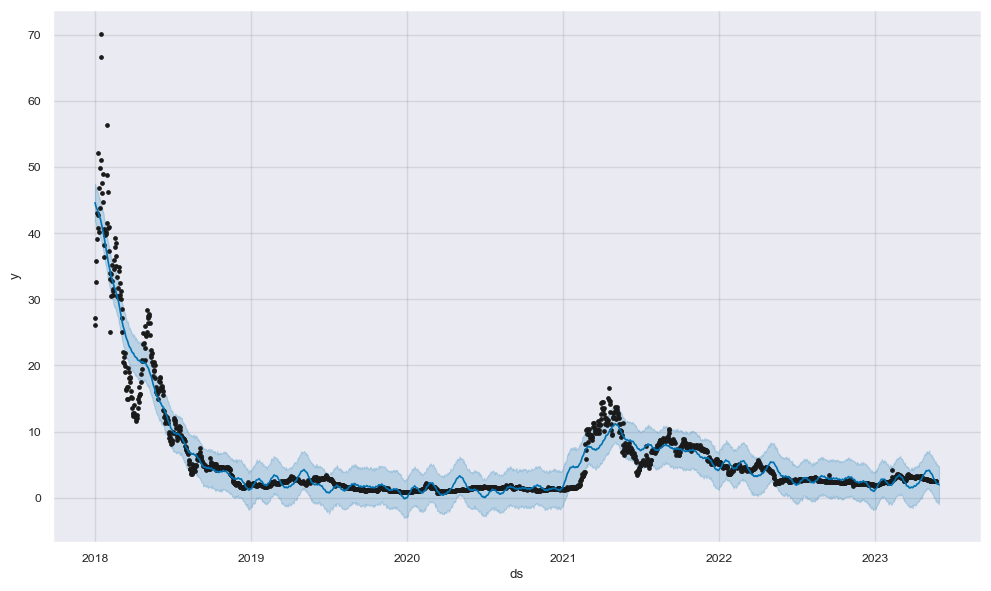

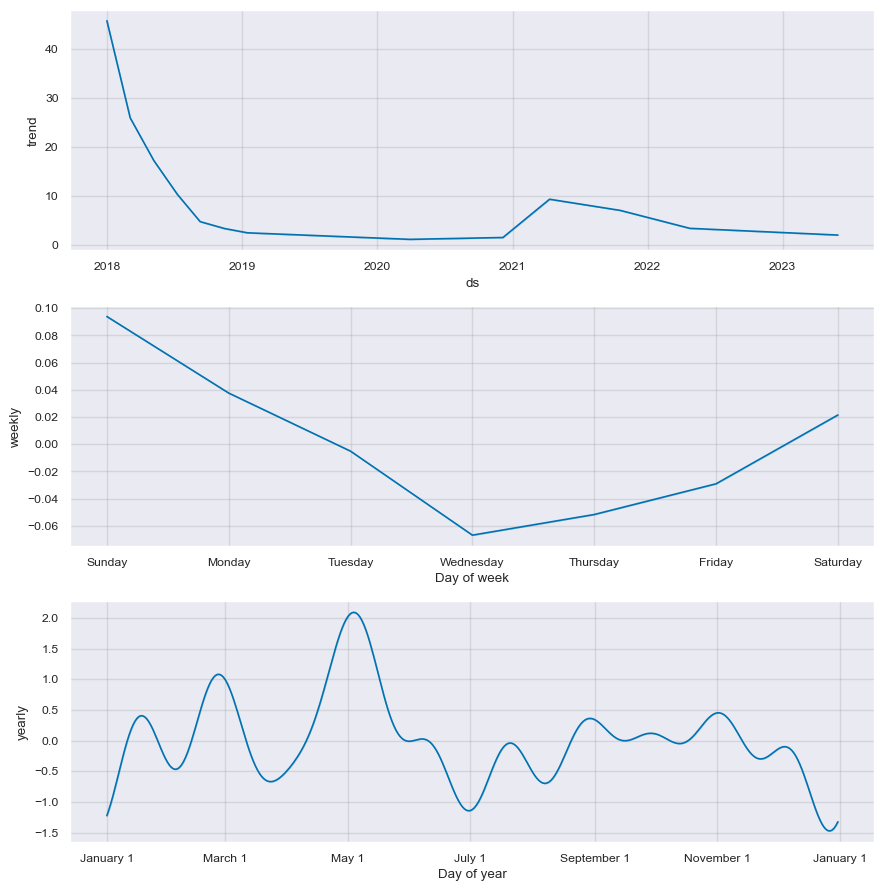

In [175]:
from prophet.plot import plot_plotly, plot_components_plotly

# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()

Gráfico de las predicciones:
Este gráfico muestra los datos históricos junto con las predicciones realizadas por el modelo. La línea azul representa los datos observados en el conjunto de entrenamiento, mientras que la línea negra muestra las predicciones realizadas por el modelo. El área sombreada en azul claro representa el intervalo de confianza al 95% de las predicciones.
El gráfico también muestra algunos puntos especiales:

Los círculos negros representan los datos observados en el conjunto de prueba (datos futuros no conocidos por el modelo).
El círculo azul oscuro representa el último dato conocido en el conjunto de entrenamiento.
El círculo verde muestra la fecha de corte entre los conjuntos de entrenamiento y prueba.
Este gráfico te permite evaluar visualmente qué tan bien se ajustan las predicciones del modelo a los datos observados.

Gráfico de los componentes del modelo:
Este gráfico descompone la serie temporal en sus componentes principales: tendencia, estacionalidad y efectos de días festivos. El gráfico muestra tres subgráficos:
El primer subgráfico muestra la tendencia, que es una estimación de la dirección general en la que se mueve la serie temporal a largo plazo.
El segundo subgráfico muestra la estacionalidad, que representa los patrones recurrentes o estacionales en los datos.
El tercer subgráfico muestra los efectos de los días festivos, que capturan las desviaciones específicas relacionadas con días festivos u otras ocasiones especiales.

In [176]:
test_gasn

,Date,Close
1969,2023-05-24,2.659774
1970,2023-05-25,2.610458
1971,2023-05-26,2.545363
1972,2023-05-27,2.505847
1973,2023-05-28,2.587448
1974,2023-05-29,2.688613
1975,2023-05-30,2.700953


In [200]:
# Obtener los valores reales del conjunto de prueba
test_values = test_gasn['Close'].values

# Obtener las predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

# Crear un DataFrame con las dos columnas
df_comparisongn = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

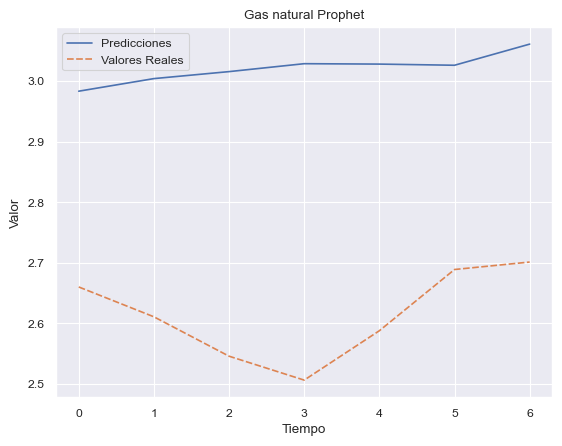

In [199]:
# Crear un gráfico lineal con las predicciones y los valores reales
sns.lineplot(data=df_comparisongn)

# Establecer título y etiquetas de los ejes
plt.title('Gas natural Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

Evaluar el modelo

In [178]:
# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.5509543624691491
MSE: 0.3160047618201488
RMSE: 0.5621430083352


MAE (Mean Absolute Error): Es el error absoluto promedio entre las predicciones y los valores reales. Representa la diferencia promedio entre las predicciones y los valores reales, sin tener en cuenta la dirección de la diferencia. Cuanto menor sea el valor del MAE, mejor será el ajuste del modelo.

MSE (Mean Squared Error): Es el error cuadrático promedio entre las predicciones y los valores reales. Calcula la diferencia cuadrática promedio entre las predicciones y los valores reales, lo que da más peso a las diferencias más grandes. Cuanto menor sea el valor del MSE, mejor será el ajuste del modelo.

RMSE (Root Mean Squared Error): Es la raíz cuadrada del MSE y representa el error promedio entre las predicciones y los valores reales en la misma escala que los datos originales. El RMSE se utiliza comúnmente para interpretar el error de predicción en la misma unidad que los datos originales. Cuanto menor sea el valor del RMSE, mejor será el ajuste del modelo.

En resumen, estos resultados indican que el modelo de Prophet tiene un error promedio absoluto (MAE) de 0.5509, un error cuadrático promedio (MSE) de 0.3160 y un error cuadrático promedio raíz (RMSE) de 0.5621. Cuanto más cercanos a cero sean estos valores, mejor será el rendimiento del modelo en la predicción de los valores reales.

# Precio del Uranio

In [179]:
uranio = pd.read_csv('data_materias/uranio.csv')
uranio = uranio.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

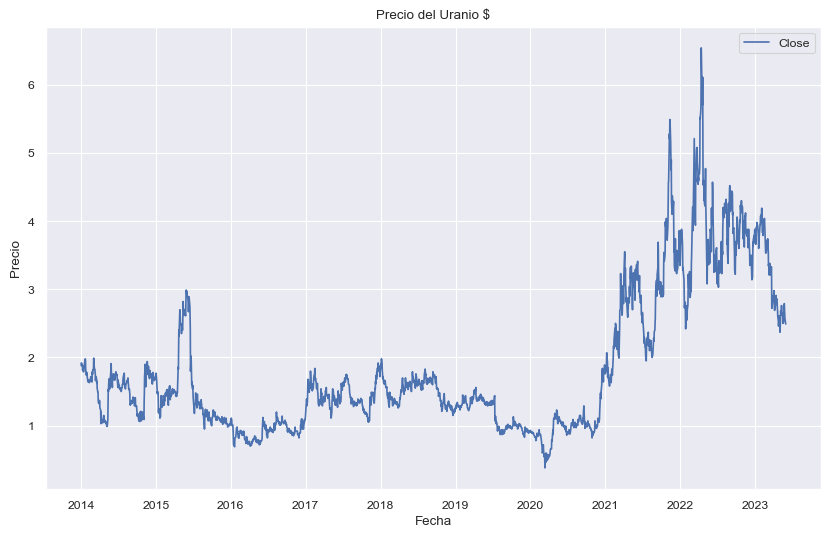

In [180]:
uranio['Date'] = pd.to_datetime(uranio['Date'])

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

sns.lineplot(x=uranio.Date,y=uranio['Close'], data=uranio['Close'])

plt.title('Precio del Uranio $')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(['Close'])

plt.show()

Filtro a partir de 2018

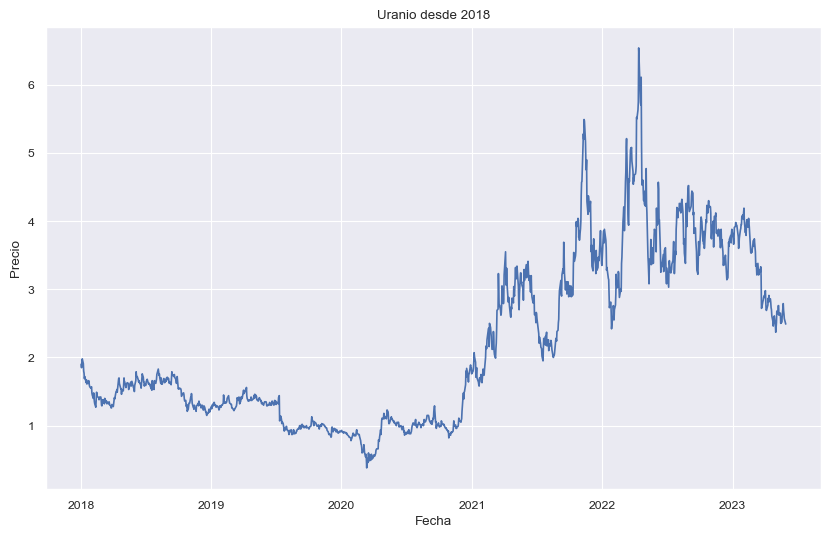

In [181]:
# Filtrar los datos desde 2018 en adelante
uranio = uranio[uranio['Date'] >= '2018-01-01']

# Visualizar los datos filtrados
sns.set(style='darkgrid', context='paper')
plt.figure(figsize=(10, 6))
sns.lineplot(x=uranio['Date'], y=uranio['Close'])
plt.title('Uranio desde 2018')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

Utilizo el mismo modelo que he empleado para las predicciones del gas natural con Prophet

In [183]:
#poner el limite de división

# Establecer la fecha límite para la división
fecha = pd.to_datetime('2023-05-24')

# Obtener el índice máximo que cumpla la condición de fecha límite
index = uranio[uranio['Date'] <= fecha]['Date'].idxmax()

# Dividir en conjuntos de entrenamiento y prueba
train_uranio = uranio[:index]
test_uranio = uranio[index:]



In [184]:

## Prophet
train_data = train_uranio[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_uranio), freq='D')   # test uranio está vacío, no está haciendo predicciones futuras

#dataframe de predicciones
forecast = model.predict(future)


13:32:21 - cmdstanpy - INFO - Chain [1] start processing
13:32:22 - cmdstanpy - INFO - Chain [1] done processing


In [185]:
train_uranio.tail()

,Date,Close
2363,2023-05-23,2.79
2364,2023-05-24,2.69
2365,2023-05-25,2.64
2366,2023-05-26,2.57
2367,2023-05-30,2.49


Gráficando resultados

C:\Users\river\AppData\Local\Temp\ipykernel_23424\329044645.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\river\AppData\Local\Temp\ipykernel_23424\329044645.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


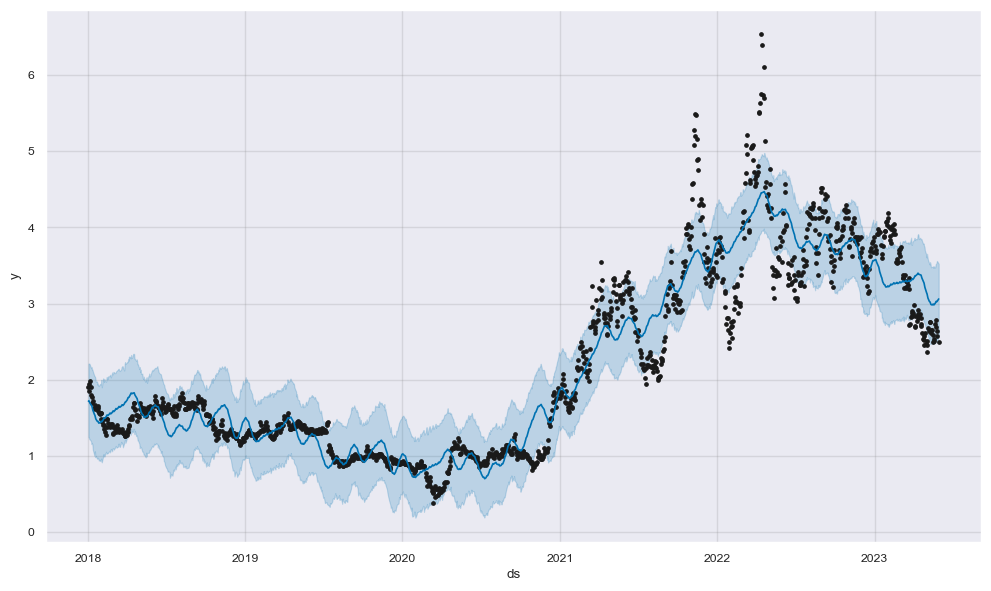

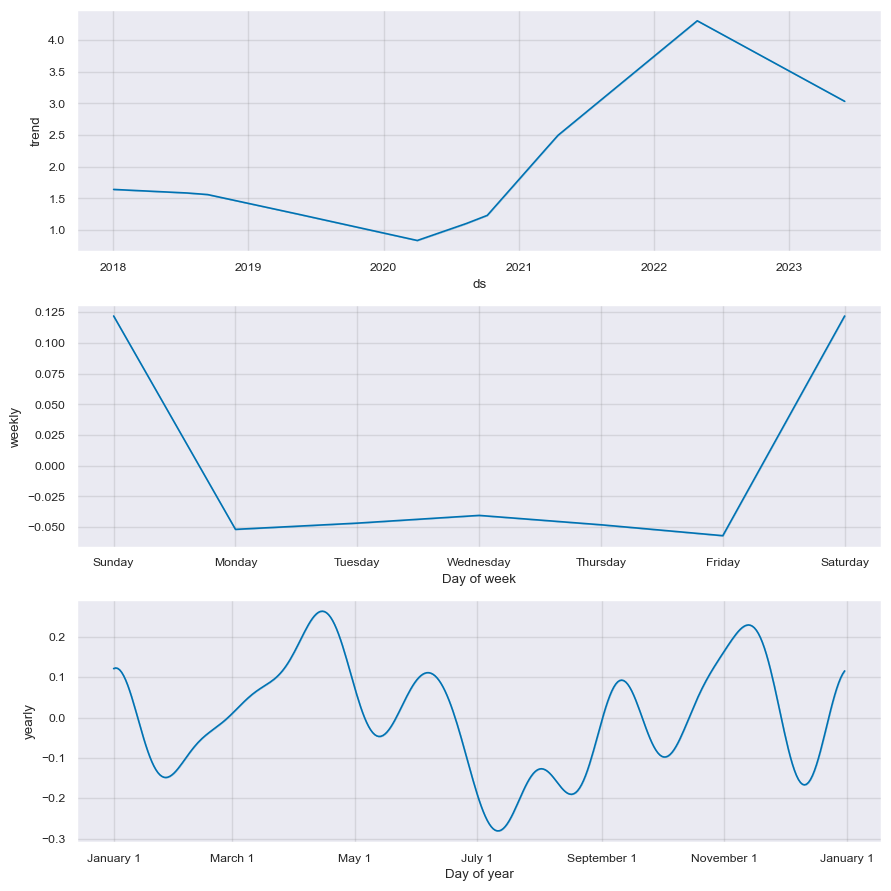

In [186]:
# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()


In [187]:
test_uranio

,Date,Close


In [190]:
# Obtener los valores reales del conjunto de prueba
test_values = train_uranio['Close'].values

# Obtener las predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]




In [194]:
# Crear un DataFrame con las dos columnas
df_comparison = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})

df_comparison.tail()

,Predicciones,Valores Reales
1356,3.015612,2.79
1357,3.028704,2.69
1358,3.028037,2.64
1359,3.026124,2.57
1360,3.061047,2.49


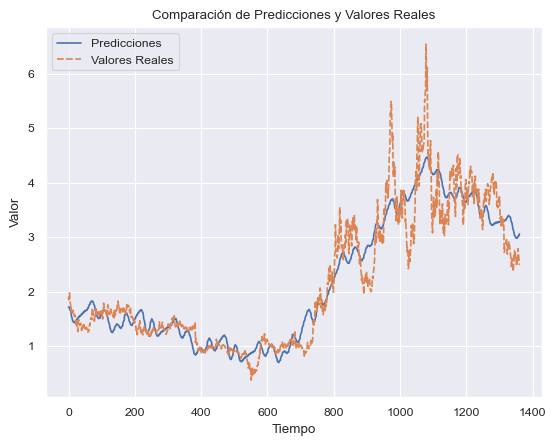

In [196]:
# Crear un gráfico lineal con las predicciones y los valores reales
sns.lineplot(data=df_comparison)

# Establecer título y etiquetas de los ejes
plt.title('Uranio Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

Evaluar el modelo

In [192]:

# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.2792777997534524
MSE: 0.1514638271812623
RMSE: 0.3891835391961771
